In [1]:
GPU_NUM = 1
GPU_ID = 2
import torch
import os
import sys
from re import I
os.environ["CUDA_VISIBLE_DEVICES"]=f"{GPU_NUM}"
#%env CUDA_VISIBLE_DEVICES=3
#torch.cuda.set_device(GPU_NUM)
device = f'cuda:{GPU_ID}'
sys.path.append('../')
from vq_gan_3d.model.vqgan import VQGAN
from dataset import MRNetDataset, BRATSDataset, ADNIDataset, DUKEDataset
import matplotlib.pyplot as plt
import SimpleITK as sitk
from ddpm import Unet3D, GaussianDiffusion, Trainer
import pytorch_ssim
from train.get_dataset import get_dataset
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.animation as animation


/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DDPM_CHECKPOINT = '/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/checkpoints/2705_model-99.pt'
VQGAN_CHECKPOINT = "/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/checkpoints/2105_e533_rc_0.12.ckpt"

USE_DATASET='BIDS'

if USE_DATASET=='LIDC':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/LIDC/model-78.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/LIDC/lightning_logs/version_0/checkpoints/epoch\=100-step\=102000-train/recon_loss\=0.33.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
				"dataset=lidc",
				f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
				"model.diffusion_img_size=16",
				"model.diffusion_depth_size=16",
				"model.diffusion_num_channels=8",
				"model.dim_mults=[1,2,4,8]",
				"model.batch_size=40 ",
				"model.gpus=0 ",
				])

elif USE_DATASET=='ADNI':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/ADNI/roi/model-34.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/ADNI/roi/lightning_logs/version_1/checkpoints/epoch\=99-step\=99000-train/recon_loss\=0.05.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
			 	"dataset=adni",
			 	f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
			 	"model.diffusion_img_size=32",
			 	"model.diffusion_depth_size=32",
			 	"model.diffusion_num_channels=8",
			 	"model.dim_mults=[1,2,4,8]",
			 	"model.batch_size=40 ",
			 	"model.gpus=0 ",
				])

elif USE_DATASET=='DUKE':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/DUKE/model-83.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/DUKE/lightning_logs/version_0/checkpoints/epoch\=58-step\=108000-train/recon_loss\=0.17.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
			 	"dataset=duke",
			 	f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
			 	"model.diffusion_img_size=32",
			 	"model.diffusion_depth_size=4",
			 	"model.diffusion_num_channels=8",
			 	"model.dim_mults=[1,2,4,8]",
			 	"model.batch_size=40 ",
			 	"model.gpus=0 ",
				])

elif USE_DATASET=='MRNet':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/MRNet/model-77.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/MRNet/lightning_logs/version_0/checkpoints/epoch\=126-step\=114000-train/recon_loss\=0.47.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
			 	"dataset=mrnet",
			 	f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
			 	"model.diffusion_img_size=32",
			 	"model.diffusion_depth_size=4",
			 	"model.diffusion_num_channels=8",
			 	"model.dim_mults=[1,2,4,8]",
			 	"model.batch_size=40 ",
			 	"model.gpus=0 ",
				])
			
if USE_DATASET=='BIDS':
	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
				"dataset=bids",
				"dataset.root_dir=/home/ge.polymtl.ca/p120530/Training/sci-paris",
				f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
				"model.diffusion_img_size=128",
				"model.diffusion_depth_size=8",
				"model.diffusion_num_channels=8",
				"model.dim_mults=[1,2,4,8]",
				"model.batch_size=40 ",
				f"model.gpus={GPU_ID} ",
				])

if USE_DATASET=='DEFAULT':
	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
				"dataset=default",
				"dataset.root_dir=/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/input_samples/canproco",
				f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
				"model.diffusion_img_size=128",
				"model.diffusion_depth_size=8",
				"model.diffusion_num_channels=8",
				"model.dim_mults=[1,2,4,8]",
				"model.batch_size=40 ",
				f"model.gpus={GPU_ID} ",
				])


/tmp/ipykernel_3288438/1878262597.py:75: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../config/"):


In [3]:
train_dataset, _, _ = get_dataset(cfg)

bjr
True
['T2w']
Found 14 files in /home/ge.polymtl.ca/p120530/Training/sci-paris
Found 14 files in /home/ge.polymtl.ca/p120530/Training/sci-paris


## Evaluate VQ-GAN

In [4]:
vqgan_ckpt = VQGAN_CHECKPOINT.replace("\\", "")
vqgan = VQGAN.load_from_checkpoint(vqgan_ckpt)
vqgan.decoding_diviser = 3
vqgan = vqgan.to(device)
vqgan.eval();

/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from /home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/vq_gan_3d/model/cache/vgg.pth


/tmp/ipykernel_2309597/2372538689.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(train_dataset[sample_idx]['data'][None]).to(device)


L2 loss: 0.004444759339094162


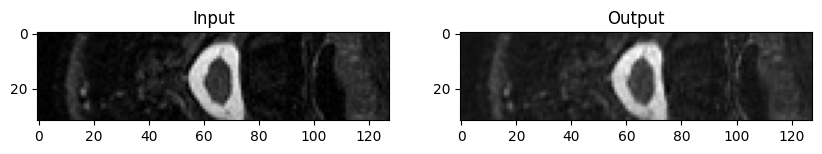

In [5]:
sample_idx = 0

input_ = torch.tensor(train_dataset[sample_idx]['data'][None]).to(device)
with torch.no_grad():
	output_ = vqgan(input_)[1]

# compute L2 loss between input and output
l2_loss = torch.nn.functional.mse_loss(input_, output_)
print(f'L2 loss: {l2_loss}')

# save input and output as 3D volumes
input_ = input_.squeeze().cpu().numpy()
output_ = output_.squeeze().cpu().numpy()

input_sitk = sitk.GetImageFromArray(input_)
output_sitk = sitk.GetImageFromArray(output_)
sitk.WriteImage(input_sitk, f'samples/1706_input_canproco_{sample_idx}_no_smoothing.nii.gz')
sitk.WriteImage(output_sitk, f'samples/1706_output_canproco_{sample_idx}_no_smoothing.nii.gz')

# save png of the midle slice
input_slice = input_[input_.shape[0]//2]
output_slice = output_[output_.shape[0]//2]
plt.imsave(f'samples/1806_input_canproco_{sample_idx}_sagital_no_split.png', input_slice, cmap='gray')
plt.imsave(f'samples/1806_output_canproco_{sample_idx}_sagital_no_split.png', output_slice, cmap='gray')

# save png of the midle slice
input_slice = input_[:,input_.shape[1]//2,:]
output_slice = output_[:,output_.shape[1]//2,:]
plt.imsave(f'samples/1806_input_canproco_{sample_idx}_coronal_no_split.png', input_slice, cmap='gray')
plt.imsave(f'samples/1806_output_canproco_{sample_idx}_coronal_no_split.png', output_slice, cmap='gray')

# save png of the midle slice
input_slice = input_[:,:,input_.shape[2]//2]
output_slice = output_[:,:,output_.shape[2]//2]
plt.imsave(f'samples/1806_input_canproco_{sample_idx}_axial_no_split.png', input_slice, cmap='gray')
plt.imsave(f'samples/1806_output_canproco_{sample_idx}_axial_no_split.png', output_slice, cmap='gray')

# Show the slices
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_slice, cmap='gray')
ax[0].set_title('Input')
ax[1].imshow(output_slice, cmap='gray')
ax[1].set_title('Output')
plt.show()




In [11]:
import pandas as pd

nb_sample = 788

l2_losses = torch.zeros(nb_sample)
dice_losses = torch.zeros(nb_sample)

for sample_idx in range(nb_sample):
    input_ = torch.tensor(train_dataset[sample_idx]['data'][None]).to(device)
    with torch.no_grad():
        output_ = vqgan(input_)[1]

    # compute L2 loss between input and output
    l2_loss = torch.nn.functional.mse_loss(input_, output_)
    l2_losses[sample_idx] = l2_loss


# Print mean and std of L2 losses
print(f'Mean L2 loss: {l2_losses.mean()}')
print(f'Std L2 loss: {l2_losses.std()}')


# save the results in a csv
df = pd.DataFrame(l2_losses.numpy(), columns=['l2_loss'])
df.to_csv('samples/1706_l2_losses', index=False)



/tmp/ipykernel_2309597/3375406460.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(train_dataset[sample_idx]['data'][None]).to(device)
/tmp/ipykernel_2309597/3375406460.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(train_dataset[sample_idx]['data'][None]).to(device)
/tmp/ipykernel_2309597/3375406460.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(train_dataset[sample_idx]['data'][None]).to(device)
/tmp/ipykernel_2309597/3375406460.py:18: UserWarning: To copy

Mean L2 loss: 0.005421945825219154
Std L2 loss: 0.0030195661820471287


                           mean       var
VGQAN decoding method                    
No split               0.005422  0.000009
Split w/ smooth        0.006592  0.000012
Split w/o smooth       0.006365  0.000010


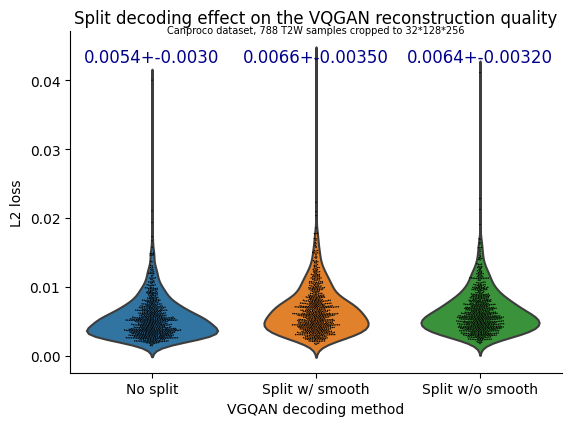

In [7]:
import seaborn as sns

#make data for ploting with seaborn
import pandas as pd
import numpy as np

splited_decoding = pd.read_csv('samples/1706_l2_losses_interpolation.csv')
single_decoding = pd.read_csv('samples/1706_l2_losses.csv')
no_smooothing = pd.read_csv('samples/1706_l2_losses_no_smoothing.csv')

M = pd.concat([single_decoding, splited_decoding,  no_smooothing], axis=0)
M['VGQAN decoding method'] = np.concatenate([np.repeat('No split', len(single_decoding)), np.repeat('Split w/ smooth', len(splited_decoding)), np.repeat('Split w/o smooth', len(no_smooothing))])
M['L2 loss'] = M['l2_loss']

g = sns.catplot(data=M, x="VGQAN decoding method", y="L2 loss", kind="violin", inner=None)
sns.swarmplot(data=M, x="VGQAN decoding method", y="L2 loss", color="k", size=1, ax=g.ax)
# Add a title
g.ax.set_title('Split decoding effect on the VQGAN reconstruction quality')
# Add a subtitle using text annotation
g.ax.text(x=0.5, y=0.99, s='Canproco dataset, 788 T2W samples cropped to 32*128*256', fontsize=7, ha='center', va='bottom', transform=g.ax.transAxes)

# Calculate mean and variance for each group
mean_var = M.groupby('VGQAN decoding method')['L2 loss'].agg(['mean', 'var'])
print(mean_var)
# Add mean and variance to the plot
for i, (method, stats) in enumerate(mean_var.iterrows()):
    g.ax.text(x=i, y=0.95, s=f'{round(stats["mean"],4)}+-{round(np.sqrt(stats["var"]),4)}0', ha='center', va='top', transform=g.ax.get_xaxis_transform(), fontsize=12, color='#00008B')

#plot
# modifu the figure size
g.fig.set_size_inches(6, 4)
plt.savefig('samples/1706_violin_plot.png')
plt.show()

## Evaluate DDPM

In [4]:
model = Unet3D(
    dim=cfg.model.diffusion_img_size,
    dim_mults=cfg.model.dim_mults,
    channels=cfg.model.diffusion_num_channels,
).cuda(GPU_ID)

diffusion = GaussianDiffusion(
    model,
    vqgan_ckpt=cfg.model.vqgan_ckpt,
    image_size=cfg.model.diffusion_img_size,
    num_frames=cfg.model.diffusion_depth_size,
    channels=cfg.model.diffusion_num_channels,
    timesteps=cfg.model.timesteps,
    # sampling_timesteps=cfg.model.sampling_timesteps,
    loss_type=cfg.model.loss_type,
    # objective=cfg.objective
).cuda(GPU_ID)


trainer = Trainer(
    diffusion,
    cfg=cfg,
    dataset=train_dataset,
    train_batch_size=cfg.model.batch_size,
    save_and_sample_every=cfg.model.save_and_sample_every,
    train_lr=cfg.model.train_lr,
    train_num_steps=cfg.model.train_num_steps,
    gradient_accumulate_every=cfg.model.gradient_accumulate_every,
    ema_decay=cfg.model.ema_decay,
    amp=cfg.model.amp,
    num_sample_rows=cfg.model.num_sample_rows,
    #results_folder=cfg.model.results_folder,
    results_folder='samples',
    num_workers=cfg.model.num_workers,
    # logger=cfg.model.logger
)



/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from /home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/vq_gan_3d/model/cache/vgg.pth
found 14 videos as gif files at None


In [5]:
#trainer.load(DDPM_CHECKPOINT, map_location=f'cuda:{GPU_ID}')
trainer.load(DDPM_CHECKPOINT, map_location=device)

In [6]:
#Comparisons function between the original and the generated images

def unsigned_difference(volume1, volume2, segmentation = None):
    """ returns |volume1 - volume2| 
    if a segmentation is provided, the difference is only computed on the segmented region
    """
    if segmentation is None:
        segmentation = np.ones(volume1.shape)
    diff = (volume1 - volume2) 
    diff = np.abs(diff) * segmentation
    return diff

def lesion_segment(diff, threshold):
    """ returns a binary mask of the region where diff > threshold
    """
    mask = np.zeros(diff.shape)
    mask[diff > threshold] = 1
    return mask

In [7]:
# diffusion functions

def img2img(sample, denoising = 0.2, comparison_mode = "Unsigned_difference", segmentation = None):
    """ Take a sample and a dataset and perform img2img diffusion,
    returns the input, the noised image before diffusion the output, and the comparison between input and ouput
    """
    input_ = torch.tensor(sample['data'][None]).to(device)
    print(input_.shape)
    noised_input = trainer.ema_model.noise_sample(input_image = input_, denoising = denoising, batch_size=1).unbind(0)[0].cpu().numpy()
    output = trainer.ema_model.sample(input_image = input_, denoising = denoising, batch_size=1).unbind(0)[0].cpu().numpy()
    input_ = input_.unbind(0)[0].cpu().numpy()
    if segmentation is not None:
        segmentation = sample[segmentation].cpu().numpy()
    if comparison_mode == "Unsigned_difference":
        comparison = unsigned_difference(input_, output, segmentation = segmentation)
    else :
        # if comparison is not specified, return a zero array
        comparison = np.zeros(input_.shape)
    return input_, noised_input, output, comparison

def img2img_dataset(dataset, denoising = 0.2, comparison_mode = "Unsigned_difference", segmentation = None):
    """ Take a dataset and perform img2img diffusion on all the samples
    returns the inputs, the noised images before diffusion the outputs, and the comparisons between input and ouputs
    """
    inputs = []
    noised_inputs = []
    outputs = []
    comparisons = []
    for i in range(len(dataset)):
        input_, noised_input, output, comparison = img2img(i, dataset, denoising = denoising, comparison_mode = comparison_mode, segmentation = segmentation)
        inputs.append(input_)
        noised_inputs.append(noised_input)
        outputs.append(output)
        comparisons.append(comparison)
    return inputs, noised_inputs, outputs, comparisons

def img2img_denoising_range(sample, denoising_range, comparison_mode = "Unsigned_difference", segmentation = None):
    """ Take an image from a dataset and perform img2img diffusion for a range of denoising values,
    returns the input, the noised image before diffusion the output, and the comparison between input and ouput
    """
    noised_inputs = []
    outputs = []
    comparisons = []
    for denoising in denoising_range:
        input_, noised_input, output, comparison = img2img(sample, denoising = denoising, comparison_mode = comparison_mode, segmentation = segmentation)
        noised_inputs.append(noised_input)
        outputs.append(output)
        comparisons.append(comparison)
        
    return input_, noised_inputs, outputs, comparisons



In [8]:
from monai.losses import DiceLoss
# Initialize the DiceLoss
dice_loss = DiceLoss(sigmoid=True)
#ploting functions

def re_orient(image):
    """ Take a 2D of a spinal coord as input oriented as expected by the model 
    and return the image oriented as expected by the conventions
    """
    return np.flip(np.rot90(image,1),1)

def normalize(image, min_ = -1, max_ = 1):
    """ Normalize the image between min_ and max_ values
    """
    return (image - np.min(image)) * (max_ - min_) / (np.max(image) - np.min(image)) + min_

def plot_img2img(input_, noised_input, output, comparison, output_file_name, denosing, mode = "gif", index = -1, lesion_segmentation_threshold = 0):
    """ Take the output of a img2img diffusion and plot the input, the noised input, the output and the comparison
    on the same figure. Save it to the given folder with appropriate name
    different modes are available : 
    - gif : all slices are displayed in a gif
    - static : only display the given slice (middle slice if index = -1)
    """
    if lesion_segmentation_threshold > 0:
        comparison = lesion_segment(comparison, lesion_segmentation_threshold)

    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    if mode == "gif":  

        # Initialize images and texts
        im = axs[0].imshow(re_orient(input_[0][0]), cmap='gray', vmin=-1, vmax=1)
        im1 = axs[1].imshow(re_orient(normalize(noised_input)[0][0]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[2].imshow(re_orient(output[0][0]), cmap='gray', vmin=-1, vmax=1)
        im3 = axs[3].imshow(re_orient(comparison[0][0]), cmap='gray', vmin=0, vmax=1)
        text = axs[0].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text1 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text2 = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text3 = axs[3].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

        # Add a title
        axs[0].set_title('Input (GT before noising)')
        axs[1].set_title(f'Noised input (noise level : {denosing})')
        axs[2].set_title(f'Output')
        axs[3].set_title(f'|input-output|>{lesion_segmentation_threshold}')

        # Update function for the animation
        def gif_update(i):
            im.set_array(re_orient(input_[0][i]))
            im1.set_array(re_orient(normalize(noised_input)[0][i]))
            im2.set_array(re_orient(output[0][i]))
            im3.set_array(re_orient(comparison[0][i]))
            text.set_text(f'Slice : {i}')
            text1.set_text(f'Slice : {i}')
            text2.set_text(f'Slice : {i}')
            text3.set_text(f'Slice : {i}')
            return [im, im1, im2, im3, text, text1, text2, text3]

        # Create the animation
        ani = animation.FuncAnimation(fig, gif_update, frames=len(output[0]), interval=200, blit=True)
        ani.save(f'{output_file_name}.gif')

    elif mode == "static":
        if index < 0:
            index = input_.shape[1]//2
        print(index)
        im = axs[0].imshow(re_orient(input_[0][index]), cmap='gray', vmin=-1, vmax=1)
        im1 = axs[1].imshow(re_orient(normalize(noised_input)[0][index]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[2].imshow(re_orient(output[0][index]), cmap='gray', vmin=-1, vmax=1)
        im3 = axs[3].imshow(re_orient(comparison[0][index]), cmap='gray', vmin=0, vmax=1)
        text = axs[0].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text1 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text2 = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text3 = axs[3].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

        # Add a title
        axs[0].set_title('Input (GT before noising)')
        axs[1].set_title(f'Noised input (noise level : {denosing})')
        axs[2].set_title(f'Output')
        axs[3].set_title(f'|input-output|>{lesion_segmentation_threshold}')
        plt.savefig(f'{output_file_name}.png')
    else:
        print("Mode not recognized, please choose between gif and static")

def plot_img2img_segmentation(input_, output, comparison, GT, output_file_name, denosing, mode = "gif", index = -1, lesion_segmentation_threshold = 0):
    """
    Take the output of a img2img diffusion and plot the input, the output, the comparison and the GT segmentation
    Save it to the given folder with appropriate name
    different modes are available : 
    - gif : all slices are displayed in a gif
    - static : only display the given slice (middle slice if index = -1)
    """
    if lesion_segmentation_threshold > 0:
        comparison = lesion_segment(comparison, lesion_segmentation_threshold)

    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    if mode == "gif":  

        # Initialize images and texts
        im = axs[0].imshow(re_orient(input_[0][0]), cmap='gray', vmin=-1, vmax=1)
        im1 = axs[1].imshow(re_orient(output[0][0]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[2].imshow(re_orient(comparison[0][0]), cmap='gray', vmin=0, vmax=1)
        im3 = axs[3].imshow(re_orient(GT[0][0]), cmap='gray', vmin=0, vmax=1)
        text = axs[0].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text1 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text2 = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text3 = axs[3].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

        # Add a title
        dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
        L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
        axs[0].set_title('Input (GT before noising)')
        axs[1].set_title(f'Output (noise level : {denosing})')
        axs[2].set_title(f'|input-output|>{lesion_segmentation_threshold}, L2 : {round(L2*10000,2)}*10e-4')
        axs[3].set_title(f'GT')

        # Update function for the animation
        def gif_update(i):
            im.set_array(re_orient(input_[0][i]))
            im1.set_array(re_orient(output[0][i]))
            im2.set_array(re_orient(comparison[0][i]))
            im3.set_array(re_orient(GT[0][i]))
            text.set_text(f'Slice : {i}')
            text1.set_text(f'Slice : {i}')
            text2.set_text(f'Slice : {i}')
            text3.set_text(f'Slice : {i}')
            return [im, im1, im2, im3, text, text1, text2, text3]

        # Create the animation
        ani = animation.FuncAnimation(fig, gif_update, frames=len(output[0]), interval=200, blit=True)
        ani.save(f'{output_file_name}.gif')

    elif mode == "static":
        if index < 0:
            index = input_.shape[1]//2
        print(index)
        im = axs[0].imshow(re_orient(input_[0][index]), cmap='gray', vmin=-1, vmax=1)
        im1 = axs[1].imshow(re_orient(output[0][index]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[2].imshow(re_orient(comparison[0][index]), cmap='gray', vmin=0, vmax=1)
        im3 = axs[3].imshow(re_orient(GT[0][index]), cmap='gray', vmin=0, vmax=1)
        text = axs[0].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text1 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text2 = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text3 = axs[3].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

        # Add a title
        dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
        L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
        axs[0].set_title('Input (GT before noising)')
        axs[1].set_title(f'Output (noise level : {denosing})')
        axs[2].set_title(f'|input-output|>{lesion_segmentation_threshold}, L2 : {round(L2*10000,2)}*10e-4')
        axs[3].set_title(f'GT')
        plt.savefig(f'{output_file_name}.png')
    else:
        print("Mode not recognized, please choose between gif and static")


def plot_img2img_denoising_range(input_, noised_inputs, outputs, comparisons, denoising_range, output_file_name, index = -1, lesion_segmentation_threshold=0):
    """ Take the output of a img2img diffusion for a range of denoising values and plot the input, the noised input, the output and the comparison
    on the same figure. Save it to the given folder with appropriate name
    different modes are available : 
    """
    if index == -1:
        index = input_.shape[0]//2
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    for i in range(len(denoising_range)):
        # Initialize images and texts
        im = axs[2].imshow(re_orient(outputs[0][0][index]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[1].imshow(re_orient(normalize(noised_inputs[0])[0][index]), cmap='gray', vmin=-1, vmax=1)
        im3 = axs[0].imshow(re_orient(input_[0][index]), cmap='gray', vmin=-1, vmax=1)
        im4 = axs[3].imshow(re_orient(comparisons[0][0][index]), cmap='gray', vmin=0, vmax=1)
        text = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=1))
        text2 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=1))
        text3 = axs[3].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=1))

        # Add a title
        axs[2].set_title(f'Output')
        axs[1].set_title(f'Noised input')
        axs[0].set_title('Input (GT before noising)')
        axs[3].set_title(f'|input-output|> {lesion_segmentation_threshold}')

        # Update function for the animation
        def gif_update(i):
            im.set_array(re_orient(outputs[i][0][index]))
            im2.set_array(re_orient(normalize(noised_inputs[i])[0][index]))
            im3.set_array(re_orient(input_[0][index]))
            im4.set_array(re_orient(comparisons[i][0][index]))
            text.set_text(f'Noise level : {int(denoising_range[i]*100)}%')
            text2.set_text(f'Noise level : {int(denoising_range[i]*100)}%')
            text3.set_text(f'Noise level : {int(denoising_range[i]*100)}%')
            return [im, im2, im3, im4, text, text2, text3]

        # Create the animation
        ani = animation.FuncAnimation(fig, gif_update, frames=len(outputs), interval=800, blit=True)
        ani.save(f'{output_file_name}.gif')





In [9]:
# use the function to get the input, noised input, output and comparison
sample_index = 8
denosing = 0.20
segmentation = "seg-manual"
sample = train_dataset[sample_index]
input_, noised_input, output, comparison = img2img(sample, denoising = denosing, comparison_mode = "Unsigned_difference", segmentation = segmentation)

print(input_.shape, noised_input.shape, output.shape, comparison.shape)

/tmp/ipykernel_3288438/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(sample['data'][None]).to(device)


torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


(1, 32, 256, 256) (1, 32, 256, 256) (1, 32, 256, 256) (1, 32, 256, 256)


16


/tmp/ipykernel_2198715/920875515.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_2198715/920875515.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()


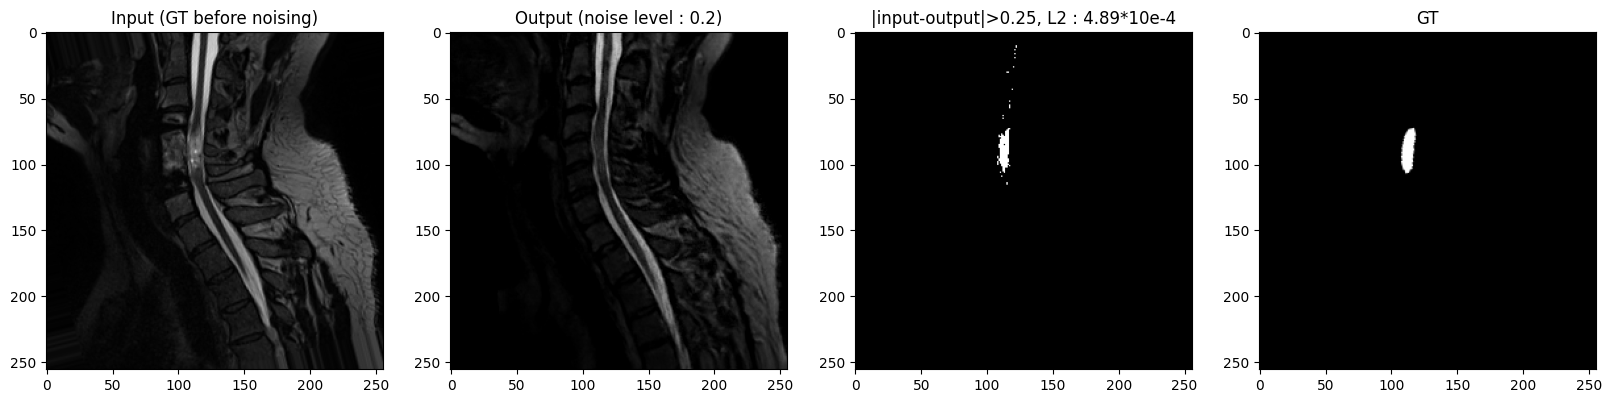

In [84]:
output_folder="/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/infered_figures"
#plot the gif of the diffusion
lesion_segmentation_threshold = 0.25
GT = normalize(sample["lesion-manual"], min_ =0)
mode = 'static'
plot_img2img_segmentation(input_, output, comparison, GT, f"{output_folder}/lesion_segmentaiton_tr_{lesion_segmentation_threshold}_{mode}_sci_paris_{sample_index}_d={str(round(denosing,2))}_{segmentation}", denosing, mode = mode, lesion_segmentation_threshold = lesion_segmentation_threshold)

In [100]:
sample_index = 8
sample = train_dataset[sample_index]
GT = normalize(sample["lesion-manual"], min_ =0)
segmentation = "seg-manual"
output_folder="/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/infered_figures"
denosing_range = np.arange(0.0, 0.9, 0.05)
treshold_range = np.arange(0.1, 1, 0.01)
L2_matrix = np.zeros((len(denosing_range), len(treshold_range)))
for denoising in denosing_range:
    input_, noised_input, output, comparison = img2img(sample, denoising = denosing, comparison_mode = "Unsigned_difference", segmentation = segmentation)
    for lesion_segmentation_threshold in treshold_range:
        seg = lesion_segment(comparison, lesion_segmentation_threshold)
        # compute the dice loss
        dl  = dice_loss(torch.tensor(seg).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
        L2 = torch.nn.functional.mse_loss(torch.tensor(seg).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
        print(L2)
        L2_matrix[np.where(denosing_range == denoising), np.where(treshold_range == lesion_segmentation_threshold)] = L2
    


/tmp/ipykernel_2198715/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(sample['data'][None]).to(device)


torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.72it/s]
/tmp/ipykernel_2198715/49203547.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(seg).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_2198715/49203547.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(seg).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()


0.0034372806530598133
0.0032097741775274327
0.002984891567148647
0.0027859294463503615
0.00257916274504621
0.0023669791036440234
0.0021697209434947623
0.00199556314349824
0.001812127958270119
0.0016397247228632148
0.0014731338322937408
0.0013480694739114083
0.0012030208096140875
0.0010975817305764923
0.0009905833071395152
0.0008957624998304664
0.0008198159243166694
0.0007382295912707782
0.0006813288272342509
0.0006374405824944747
0.0006079592375132111
0.000579997102910778
0.0005688634691482946
0.0005576652363876604
0.0005504120413404192
0.0005472164335797882
0.0005451615501057429
0.0005476231876306737
0.0005506941841934999
0.0005573018378674955
0.000564808080357292
0.0005692459231900638
0.0005871562745929249
0.0006011587198975088
0.0006083169805697219
0.0006207147430308135
0.0006334383961876676
0.000644051236344577
0.000656195026424765
0.0006712396368533256
0.0006848578206961486
0.0006958344993839171
0.0007102311867497202
0.0007224017650584324
0.000732811537395005
0.0007520407716923183

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.71it/s]


0.0036095626229342135
0.0033798842320431595
0.003156707287978341
0.0029270544480157717
0.002705845637236188
0.0025103977400937564
0.0023152829323946854
0.0021229262472117695
0.0019397359397017517
0.0017621274367993689
0.0015996069293262502
0.0014386909472865386
0.0012976670367337204
0.001158535875793944
0.0010500307509835227
0.0009473289204653298
0.0008636318915062786
0.0007970546080155908
0.0007259854632313157
0.0006766391527925796
0.0006353877138487339
0.0005899435448235453
0.0005566889003267734
0.0005303909230696007
0.0005162592491549815
0.0004975426427320398
0.0004885053534400154
0.0004916775179657375
0.0004886744077217
0.00048675326265822284
0.0004906574620113669
0.0004997785533780042
0.0005052074898037485
0.0005148411452557832
0.0005310274144909466
0.0005423599760254627
0.0005530917294704773
0.0005699870355668645
0.0005802799322991314
0.0005964344323443492
0.000609780148734128
0.0006278442318630049
0.0006400363385436912
0.000655151914562989
0.0006706199119703592
0.000685085306449

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.0035161256897027183
0.003278017018290888
0.00303625880058633
0.0028262606642057665
0.002609113373372102
0.0024132322944592165
0.0022180640368401
0.002029919719700894
0.001837310206306279
0.0016713155306018388
0.0015155031986548908
0.0013603696933384055
0.0012142243835679871
0.001096301097036835
0.0009808895671750036
0.0008821049628597759
0.0008120751615028235
0.0007480658070912918
0.0006943532951704134
0.0006489263214037753
0.0006176736140555024
0.0005796128538977257
0.0005632312121692678
0.0005476589075625751
0.0005433548026429916
0.0005359435582390373
0.0005305519484564027
0.0005333275135852456
0.0005312300185364872
0.0005340537321372064
0.0005387491567587655
0.0005472575000864278
0.0005568082137570196
0.0005614516802678759
0.0005713743515214242
0.0005859797025477997
0.0006006232720976322
0.0006227150472055564
0.0006377921648079586
0.0006555909907304135
0.000666630294828817
0.0006834221206999268
0.0007029208938489227
0.0007208885555540655
0.0007361644446943637
0.0007484519042348801

sampling loop time step:  20%|██        | 60/300 [00:22<01:29,  2.70it/s]


0.00360655903435325
0.0033817452237332435
0.0031790165665224164
0.0029585371680933524
0.002740849254591944
0.002527898623948083
0.0023329591451133275
0.0021341462391493084
0.0019285338700327712
0.0017606734211319454
0.0015858086091071674
0.0014161130423175818
0.00124806045280045
0.0011057324883916213
0.0009710660434545282
0.0008601475955809407
0.000779821505735512
0.0007037416374138128
0.0006383553981712418
0.000589355355619758
0.0005518055088748914
0.0005231317562366272
0.0004937767062120783
0.0004832064162816222
0.00047245650589043865
0.0004642425042506883
0.0004687452309897079
0.0004736524104098517
0.0004735825859862753
0.0004813701781538494
0.000490471985355111
0.0004957812040535681
0.000512880699334627
0.0005276053089053757
0.000546408618676818
0.0005610752260045581
0.0005746794958574208
0.0005924227433828798
0.0006132599580210717
0.0006299767299309132
0.0006467261625060382
0.0006624151787717346
0.0006769005579398844
0.0006948379374789192
0.0007113139219667595
0.000728465198021265

sampling loop time step:  20%|██        | 60/300 [00:22<01:29,  2.69it/s]


0.0036565342287517835
0.0034169200793618937
0.003202791481832443
0.0029797621445335452
0.002760856041060129
0.0025583868834657634
0.0023469190666118795
0.002151844972755772
0.00195157870517048
0.0017762116834663037
0.0016086187268799987
0.0014302069441707223
0.0013046108816747635
0.0011734471834912068
0.0010397456530592997
0.0009332641792663029
0.000835957664541354
0.000759142367417354
0.0006901198026973864
0.0006338006262602723
0.0005803786389180106
0.0005464610594671955
0.0005178555329650053
0.00048711186030135834
0.00046986459199093084
0.0004619485484191767
0.00045656141317994465
0.00045727655348247643
0.0004620727938642201
0.0004704336151759459
0.0004780710482903284
0.000488475004955401
0.0004958248276081146
0.0005084642569441623
0.0005173092065631092
0.00053131577907649
0.0005456953704323519
0.0005623369656630894
0.0005757180032814768
0.0005897362796416382
0.000601092798780055
0.0006184344279544938
0.0006346150123503913
0.0006546327689333929
0.0006687037874490863
0.000688311683939

sampling loop time step:  20%|██        | 60/300 [00:22<01:29,  2.70it/s]


0.003377006770202804
0.003142582950191649
0.0029191588517161154
0.0026926953310333302
0.0024948489590919058
0.0022945118322139574
0.00208933729198612
0.001904055838162215
0.0017412274479457958
0.0015809457828925761
0.0014272853684023003
0.0012907022357300144
0.0011715318612512864
0.0010619364611179527
0.0009616328885553202
0.0008762385658231846
0.0008008454979704263
0.0007304834160850482
0.0006821821429527807
0.0006427829605615162
0.0006098184584148897
0.0005781765616090667
0.0005571837383426696
0.0005449471530793884
0.0005410317862575166
0.0005347191621167692
0.0005443184511248913
0.0005472361873002252
0.0005510629132265844
0.0005574422705214455
0.0005630278576680292
0.0005721512764458192
0.0005863179413429942
0.0006038937824561652
0.0006150605194383696
0.0006245614058590798
0.0006344160423685674
0.0006479324637942307
0.0006635301781712109
0.0006771083391667752
0.0006966586575300902
0.0007111985665899532
0.0007279413705616343
0.0007425304197197101
0.0007511134861373102
0.0007680689372

sampling loop time step:  20%|██        | 60/300 [00:22<01:29,  2.70it/s]


0.003533412292381131
0.0033110184596438753
0.0030918000297839275
0.0028740117366836643
0.002657947638504461
0.0024706047346156838
0.002272386356000794
0.002078405798314525
0.0018883745051065863
0.0017107277333594443
0.0015692183806277269
0.0014248629511084323
0.001279237702451965
0.0011577250305629854
0.001045339896119869
0.0009503477648957657
0.0008580380508649183
0.0007632635601917296
0.0007063488606429027
0.000649026033525002
0.0006094911763805276
0.0005732380323701821
0.000541389793181179
0.0005153223711469195
0.0004973123999827293
0.0004868719123367497
0.0004783000981165456
0.0004743194794445284
0.0004720529068224946
0.00047404649581060844
0.00047090951552796086
0.00047512908812329287
0.000482203769223798
0.0004913000850665806
0.0004998057294029901
0.0005086889575294119
0.0005269816977515485
0.0005434599915601235
0.0005558969123937596
0.0005704828752739354
0.0005830575666563185
0.0005974909934762672
0.000614597943146432
0.0006280559001778806
0.0006424834368117126
0.000654290158023

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.00362821658749035
0.0033665574245242942
0.003136066249912025
0.002891985462230236
0.0026415623811744072
0.0024221915714150947
0.0022077940088653875
0.002003346026783419
0.0018159626223921348
0.0016272139365893698
0.0014646492367331645
0.0013136868848659853
0.0011689312662417255
0.0010615589518241275
0.0009285336195412505
0.0008254230733075634
0.0007324885347947843
0.0006704147317939557
0.0006089389518233343
0.0005556506152852743
0.0005217559804815302
0.0005024079687554355
0.00047467796068433244
0.00046008775991411755
0.00045304325844795957
0.0004532375166112925
0.000449667191164448
0.0004548838093987196
0.0004608262230709637
0.0004727944826561237
0.0004796691359010163
0.0004954546222981515
0.0005034266958594424
0.000519886095512444
0.0005310208400130955
0.0005449989184837955
0.0005588524225628044
0.0005759750523976914
0.0005905927009293032
0.0006101509177425123
0.0006331922031945646
0.0006492902707846292
0.0006607343599169689
0.0006773728555826573
0.000689440316369737
0.0007052611832

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.0035015155296096428
0.0032805245971867488
0.0030757867877997357
0.002861017509249382
0.0026379209052782523
0.0024459802843690374
0.002256051289075239
0.002062705972444505
0.0018799872540236
0.0016866512703494962
0.0015197471929595443
0.0013755222862985492
0.0012401486922715048
0.0011138686707821046
0.001007528146591098
0.0009116093541410193
0.0008241629852891901
0.0007518846399465652
0.0006922432625311336
0.0006481972738934137
0.0006063463301251178
0.0005770266026259179
0.0005622600384837966
0.0005349127926434931
0.0005193514354486664
0.0005143517608614415
0.0005079199256938662
0.0005023181266088241
0.00050138620517458
0.0005081799092343398
0.0005170006108932024
0.0005208896642605477
0.0005326229495798851
0.0005485442889485592
0.0005626445386488365
0.000577228667810058
0.0005902607725920428
0.0006064315858600333
0.0006221899532674479
0.0006380129863698835
0.0006510635188503465
0.0006661957039482012
0.0006866394857694012
0.000704418072265721
0.0007233737634903968
0.0007359213702768806

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.0033862711910350703
0.0031432243210469638
0.0029096520382900747
0.0026759656140056217
0.002454995420540834
0.0022477745015172463
0.0020473863939058858
0.001875568115698993
0.0017031457816174469
0.00155502364005721
0.0014083565000133549
0.0012740691609274177
0.001135807480127972
0.0010268416622978185
0.0009206014223537182
0.0008246990016751337
0.0007384914876518048
0.0006754549990113269
0.0006249243240177171
0.0005767936268654569
0.0005334153635161317
0.0005046550335265792
0.00048321050085607876
0.0004722638518217408
0.0004686349264304438
0.0004557102298463503
0.00045368565098445797
0.0004591615915281334
0.0004673443567206771
0.00047064891062052923
0.00047094245777244866
0.0004783976667026447
0.0004880765859154191
0.0005021983047426171
0.0005151161561995788
0.0005299407611529684
0.0005437693214871297
0.0005565334728585436
0.0005709892189200581
0.0005896857825986466
0.0006071718544993097
0.0006210816820895069
0.0006359309415968504
0.000647381958705605
0.0006630105469353929
0.0006760559

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.0035602254834952145
0.0033328754164969583
0.0031151689443511517
0.002884720059402209
0.0026509222104635867
0.0024374772810435933
0.0022431674744200986
0.0020299614427503544
0.0018402519196551931
0.0016559139299292458
0.0014957271712379067
0.0013447592037418767
0.0012001887417436483
0.0010752292156534964
0.0009551659367044063
0.0008688106909404588
0.0007932098414415894
0.0007184453297186424
0.0006489067268107163
0.0005922561278823733
0.0005595576795671572
0.000524744984410785
0.0004931964258985005
0.00046429779656008625
0.0004526386852374712
0.00044491864290762035
0.0004398401924296959
0.0004417843261654721
0.0004433055317909374
0.0004531258274573669
0.00045178124758592404
0.00046180155582419176
0.0004709367912261053
0.00048249683001898465
0.0004943741347622643
0.0005087491202948479
0.0005222610090902402
0.0005311199305799585
0.000542747017578048
0.0005605613906445194
0.0005774257788664238
0.0005946592426388941
0.0006077985962582455
0.0006263216058164254
0.000637788439482133
0.0006479

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.0036564823498044232
0.00342745014697998
0.0031940820407065883
0.002970009192256203
0.0027534296421105565
0.0025449073103285206
0.0023285188703905334
0.002152433861068553
0.001964661627658508
0.0017876889212367
0.0016251639058102371
0.0014682414265114654
0.001321527645908862
0.001191430133984585
0.00106882162812182
0.0009593125084614748
0.0008608357914689951
0.000774462008736199
0.0007026990595104699
0.000648796922021011
0.0005996482065058092
0.0005520014832083193
0.0005333021524231867
0.0005083969406991399
0.0004847475594298315
0.0004715459853310447
0.0004632918233158247
0.00046409950838842596
0.00046376384329625993
0.0004635686606599843
0.00046942225731448796
0.00047769267832030617
0.00048690300494612533
0.0004942008635906314
0.0005080486070652023
0.0005228648404822389
0.0005340230457930739
0.0005497257766775443
0.0005629356229290716
0.0005712994540500882
0.0005882989596115316
0.0006071060971761676
0.0006250326251360115
0.0006365429687120604
0.0006534271710505345
0.00067000296870943

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.003469600221162714
0.0032253380132261063
0.003004679392051065
0.002791547722545969
0.002581208107277128
0.002371435959500173
0.002178108633553049
0.00200442650387566
0.0018290526031015035
0.0016788837967365222
0.0015253755164021858
0.001367119040762468
0.0012409510170290257
0.0011251375791065847
0.0010230763287364286
0.0009191386971292189
0.0008416870243206261
0.0007715848409770469
0.0007157038898661817
0.0006545752075901467
0.0006227932988409511
0.000582702892465858
0.0005562794630480256
0.0005299749770168887
0.000513873417095067
0.0005028193722760191
0.00048765478474365094
0.00048292192730258106
0.00047522758643324576
0.0004767152870057569
0.00048237870499277986
0.00048699611998003113
0.0004986745810653271
0.00050712418774722
0.000513308022801905
0.0005247053722483453
0.0005340627319638679
0.0005458027057854019
0.0005552007101370261
0.000568014330865051
0.0005798982555573638
0.0005922446937545055
0.0006041913328102987
0.000614798859343889
0.000625698983198074
0.0006413844238350884


sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.0035810010975165767
0.0033628210498914935
0.003142397077742661
0.0029227954719495096
0.002695247643780703
0.002484266780341299
0.0022848606714247427
0.002106923586190572
0.0019213549466638932
0.0017465855260854124
0.001587484977747736
0.0014571638161913118
0.001321181834987186
0.0011959321066596822
0.001079873209077532
0.0009765277226121316
0.000898673091400893
0.0008151673077085756
0.0007534742976302747
0.0006961769676438911
0.0006514416927389964
0.0006151801327762715
0.0005743893675129614
0.0005536499992386695
0.0005389577156604702
0.0005258608523368449
0.0005182280989706069
0.0005178453765799386
0.0005219295224014755
0.0005252054418731656
0.000530551153089075
0.0005350546182525274
0.000542480151741952
0.0005497971387084955
0.0005516407970758019
0.0005550977288335412
0.000566804560192079
0.0005770382541412255
0.0005916871525342026
0.0006045219858192718
0.0006221237888210817
0.0006362389198299889
0.000647459425606055
0.0006640144472085262
0.0006828137291050461
0.0007014750930862555


sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.003449568396252987
0.003198003541033054
0.0029792097760785695
0.002761857146885922
0.0025661245873529422
0.002359430348529473
0.002147719457533442
0.0019454537478127351
0.0017719535175624228
0.0015923850894061706
0.0014472020335096676
0.0013033676663232097
0.0011602723359080873
0.0010471330345174126
0.0009368497454493762
0.0008310002264111276
0.0007534490720897295
0.0006905771278380326
0.0006360167963958995
0.0005832122573716679
0.0005477245671514526
0.0005139927329251721
0.000489192638367652
0.00046909793336723444
0.0004545156587296587
0.00044432959212258234
0.00044625939344399197
0.0004431386981755704
0.00044290299198678114
0.00044838875425255893
0.00045389321727838834
0.0004582348127419745
0.00046758525696531834
0.0004804016490587026
0.0004900314655833393
0.0005026237171909964
0.0005174430489509485
0.0005314761473107376
0.0005453211516501677
0.0005562289740643644
0.0005735478491344247
0.0005869850404123121
0.00060495742876142
0.0006193670079979051
0.000634114657286343
0.0006516655

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.003521586304860101
0.003296524897076656
0.0030736854848880633
0.002864027735767212
0.002653664273878137
0.0024396895715232906
0.0022353212400776307
0.002035745861361786
0.0018555374101887272
0.0016782389696889863
0.0015167520412870867
0.0013534554764160678
0.001185851250280913
0.001053719733008486
0.0009437159670650961
0.0008455115586196609
0.0007561112866698474
0.0006834793318406418
0.0006215675286400544
0.0005739363548047268
0.0005377716582570685
0.0005150836075584636
0.0004891329263705272
0.00047256246263515023
0.0004610703425973353
0.00045479037575034593
0.00045469254957651757
0.00047082113322914794
0.0004790846646562808
0.0004886890831789937
0.000495068924488461
0.0005062853692641024
0.0005185553623994078
0.0005346671778261192
0.0005414128036369414
0.0005535153775595314
0.0005602830930639835
0.0005676613993072942
0.0005804559525996887
0.0005975444544914375
0.0006184900421273164
0.0006317990185833332
0.0006514274110058658
0.000666700727853563
0.0006843093994233094
0.0006940582807

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.0036700033532954804
0.003453315375050445
0.0032441302669137225
0.0030136030896799025
0.002794160878240466
0.002598211166352943
0.002398607481758569
0.0021886394209005224
0.0019848962084303354
0.001818167818071529
0.0016452341491897038
0.0014967670591134934
0.0013478429688908908
0.0012046506335467904
0.0010829426339429194
0.0009852473590969866
0.0008927859156664281
0.0008234960440767105
0.0007452549003252762
0.0006825015719213899
0.0006340116617116083
0.0005976502861228968
0.0005621737201322191
0.0005418148831941465
0.0005259558625445462
0.0005139830704783291
0.0005121115722295113
0.0005061717705763125
0.000514833495865329
0.0005169476892687864
0.0005248022090340466
0.0005379443970296871
0.000548706663179953
0.0005581395521956234
0.0005712102157941922
0.0005899230811705502
0.0006022267772662781
0.0006162792506414371
0.0006356878110464913
0.0006537694387687019
0.0006673145715281202
0.0006849036415117347
0.0006989239719514693
0.0007130052710506583
0.0007293232100791123
0.000741331405590

sampling loop time step:  20%|██        | 60/300 [00:22<01:28,  2.70it/s]


0.003460452746623986
0.003220112736501021
0.002989276866143028
0.0027574230436198067
0.0025370678175839993
0.0023484450283730524
0.002152357996046066
0.0019607595021293653
0.0017735148488251453
0.0016161216181516033
0.001467649575768384
0.0013323894713528261
0.0011961159908917456
0.0010724075684702583
0.0009749774604494899
0.0008737003138940998
0.0007944031412614352
0.0007221916522206386
0.000667592219538926
0.0006148444710622922
0.0005753734365538827
0.0005494264827407996
0.0005250582379392348
0.0005114848729645841
0.0004976961663152194
0.00048770186699641417
0.00048632817839887506
0.0004915574174850657
0.0005019514014625737
0.0005078500891626415
0.0005180986848449688
0.0005263445596688111
0.0005389269079947178
0.000554050290779028
0.0005698170723873341
0.0005788037041069993
0.0005923771215547868
0.0006069343084560297
0.0006179525601110891
0.0006364664109155138
0.0006487219172070946
0.0006663500301213754
0.0006845515595144001
0.0006985269652217561
0.0007166467725083657
0.0007326665066

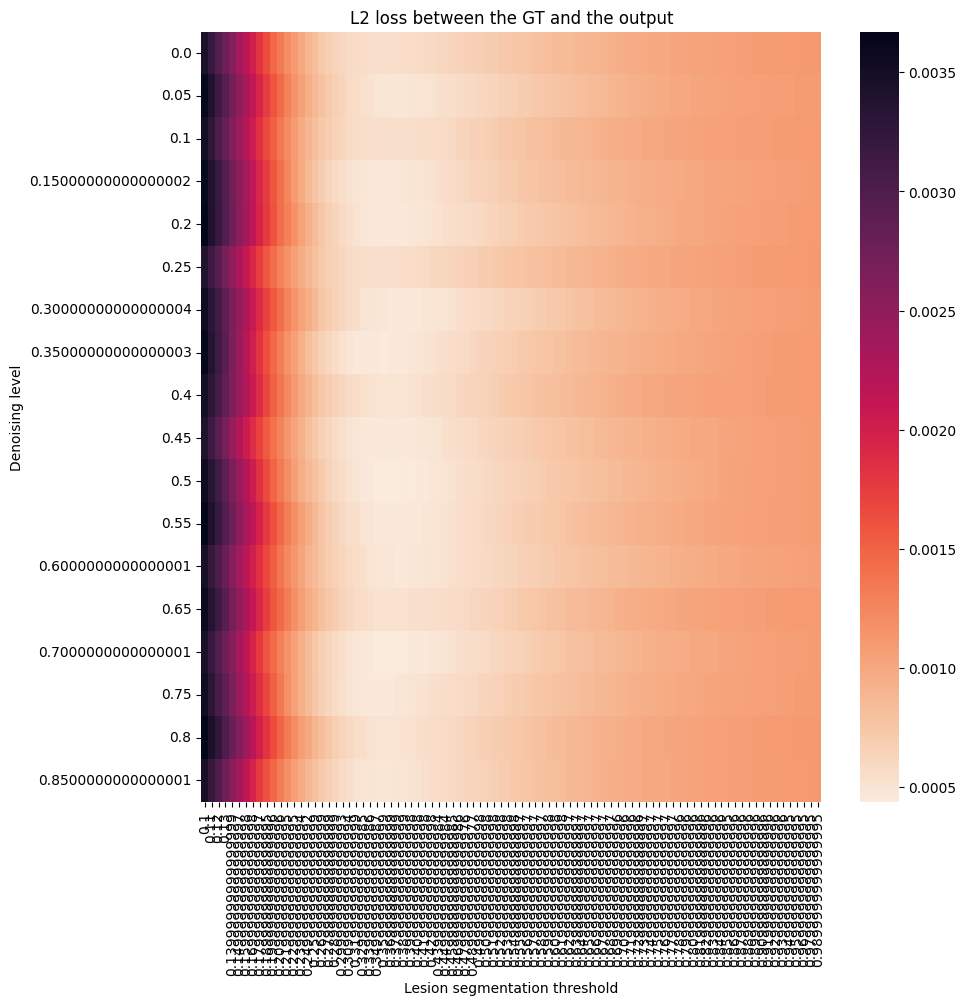

In [101]:
import seaborn as sns

# plot a 2D heat map of the L2
plt.figure(figsize=(10,10))
sns.heatmap(L2_matrix, xticklabels=treshold_range, yticklabels=denosing_range, annot=False, cmap='rocket_r')
plt.xlabel('Lesion segmentation threshold')
plt.ylabel('Denoising level')
plt.title('L2 loss between the GT and the output')
plt.savefig(f'{output_folder}/L2_loss_heatmap_{sample_index}_{segmentation}.png')
plt.show()


/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(sample['data'][None]).to(device)


torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:22,  2.72it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:22,  2.71it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.69it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.69it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.69it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.69it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.69it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.69it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.69it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.69it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.68it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.69it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_718798/3058016491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

torch.Size([1, 1, 32, 256, 256])


sampling loop time step:  25%|██▌       | 75/300 [00:27<01:23,  2.69it/s]
/tmp/ipykernel_718798/920875515.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl  = dice_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
/tmp/ipykernel_718798/920875515.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L2 = torch.nn.functional.mse_loss(torch.tensor(comparison).unsqueeze(0), torch.tensor(GT).unsqueeze(0)).item()
MovieWriter ffmpeg unavailable; using Pillow instead.


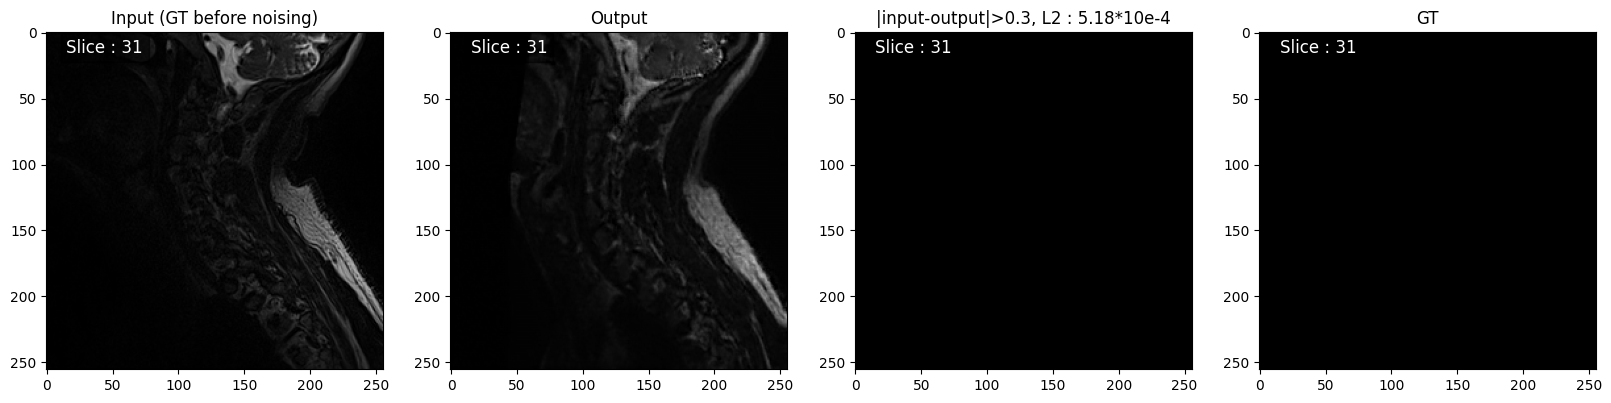

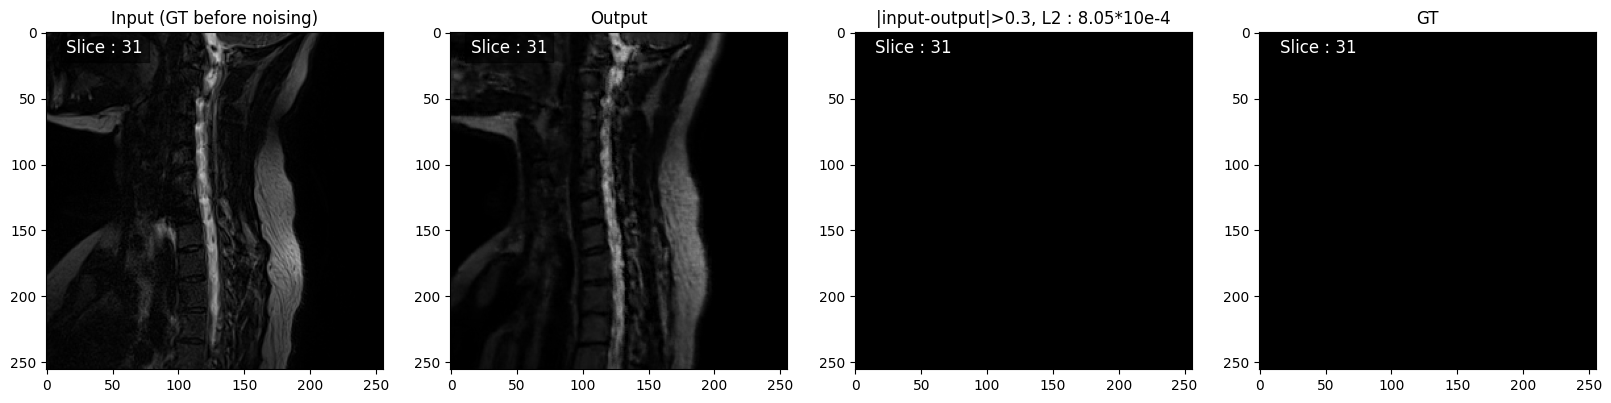

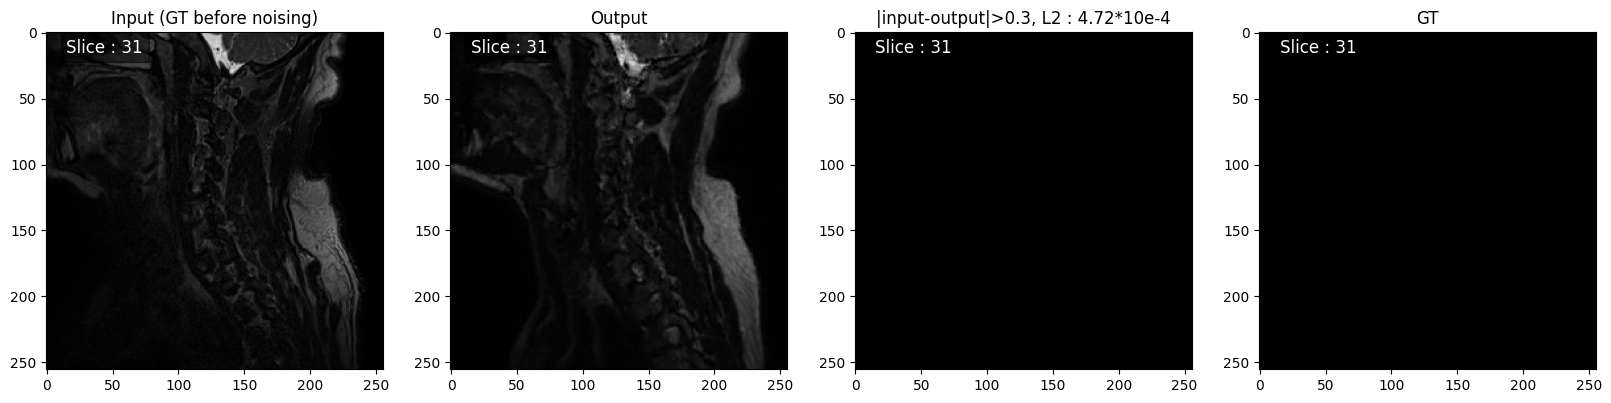

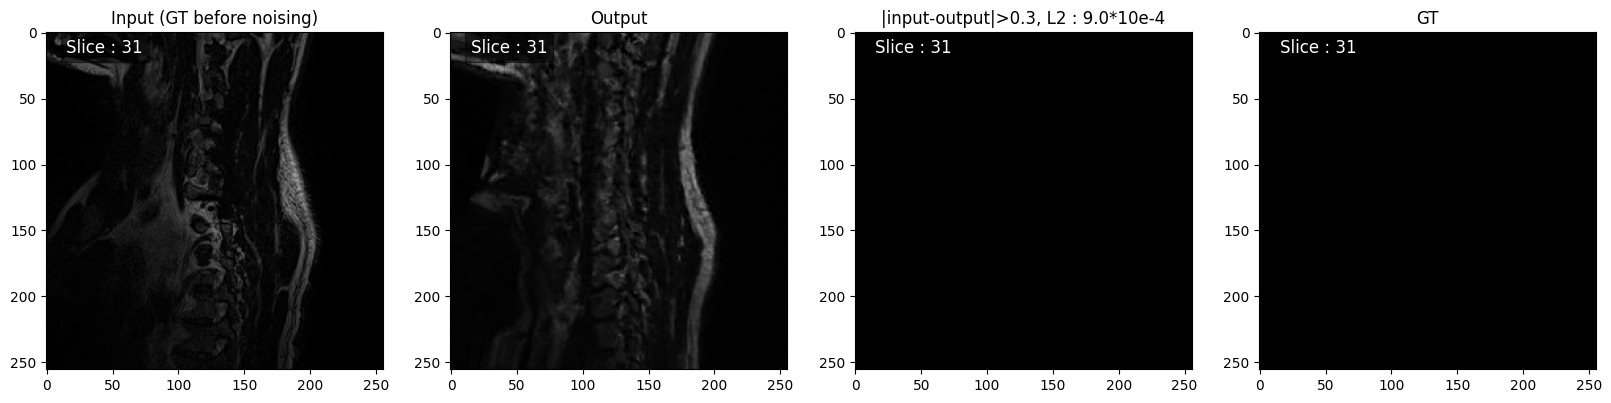

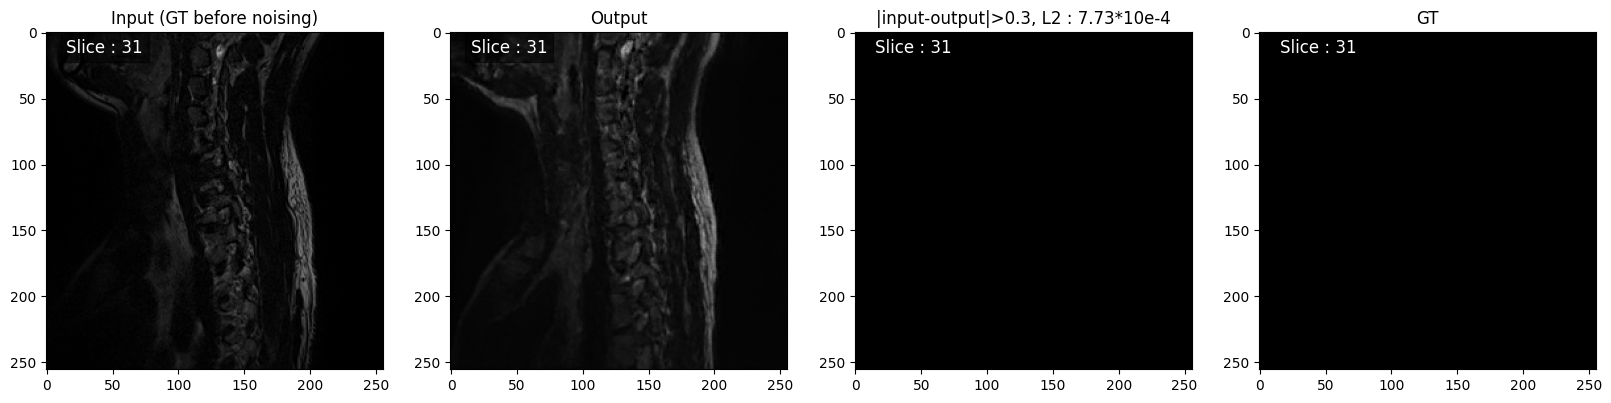

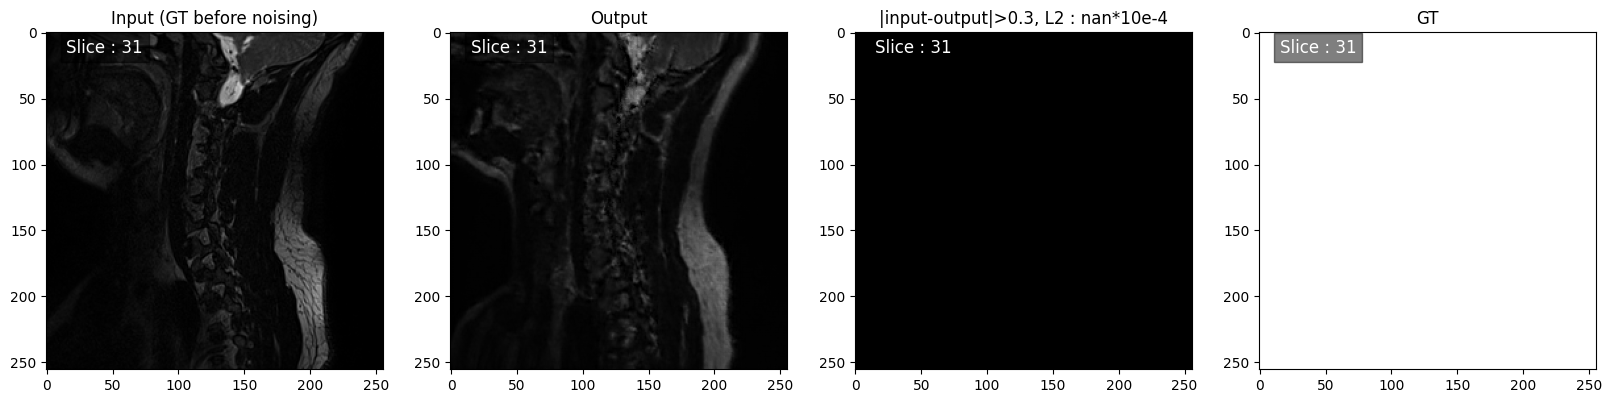

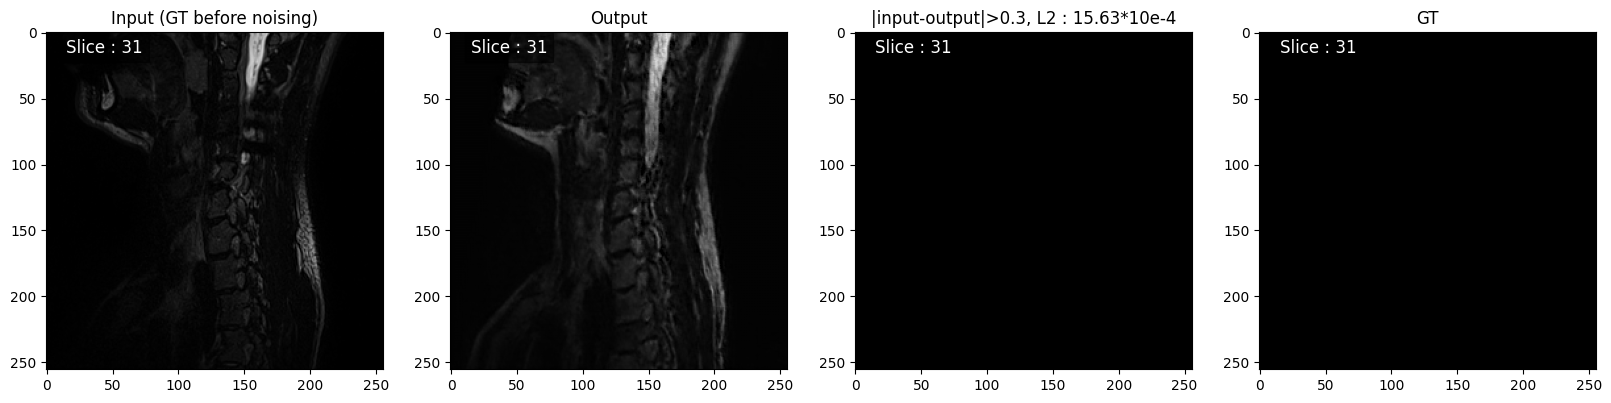

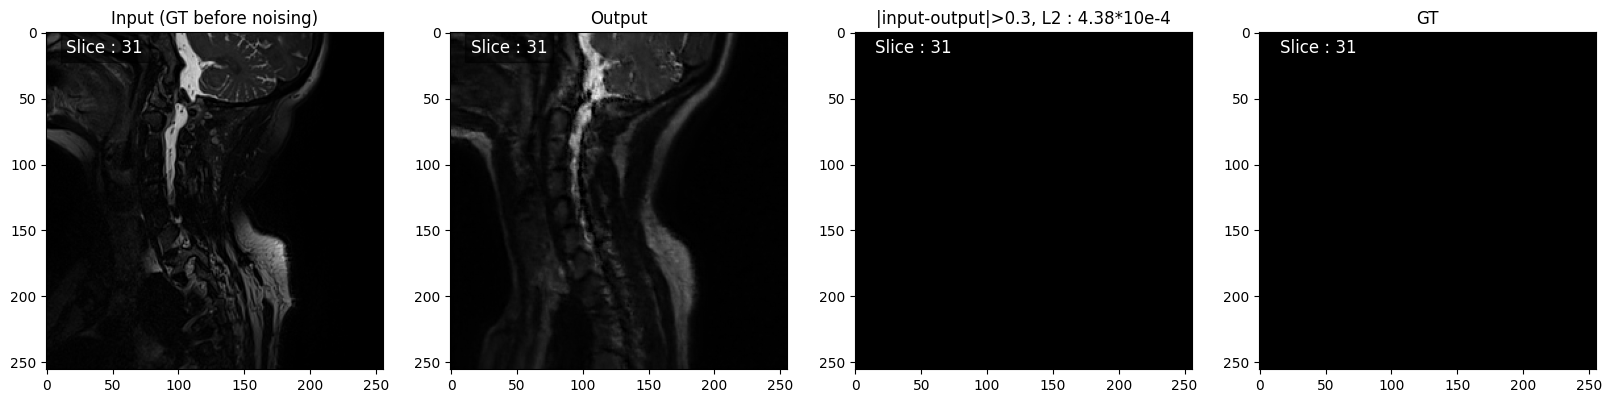

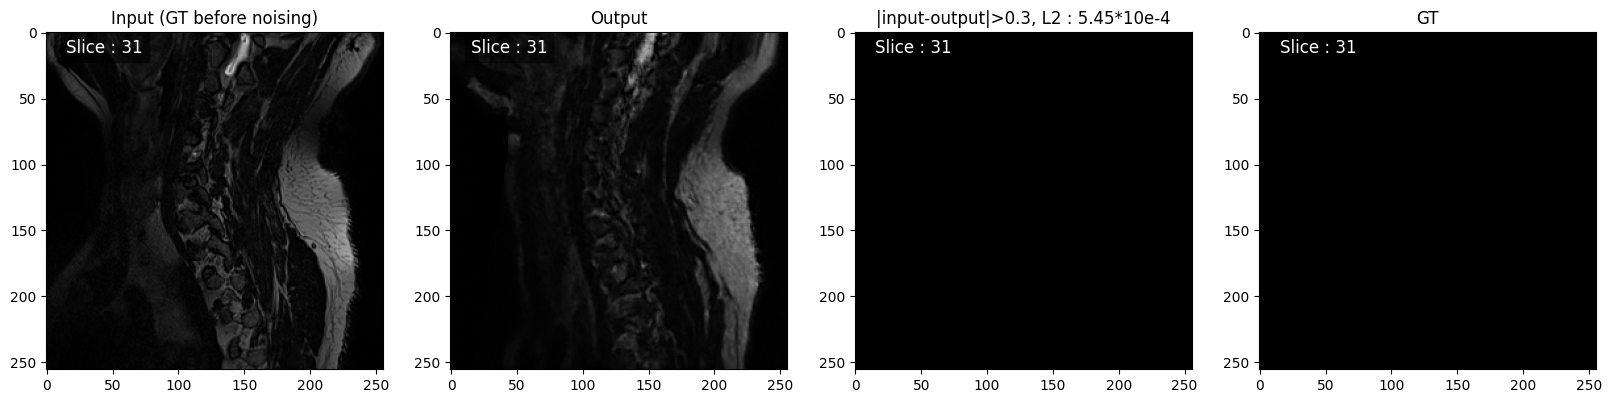

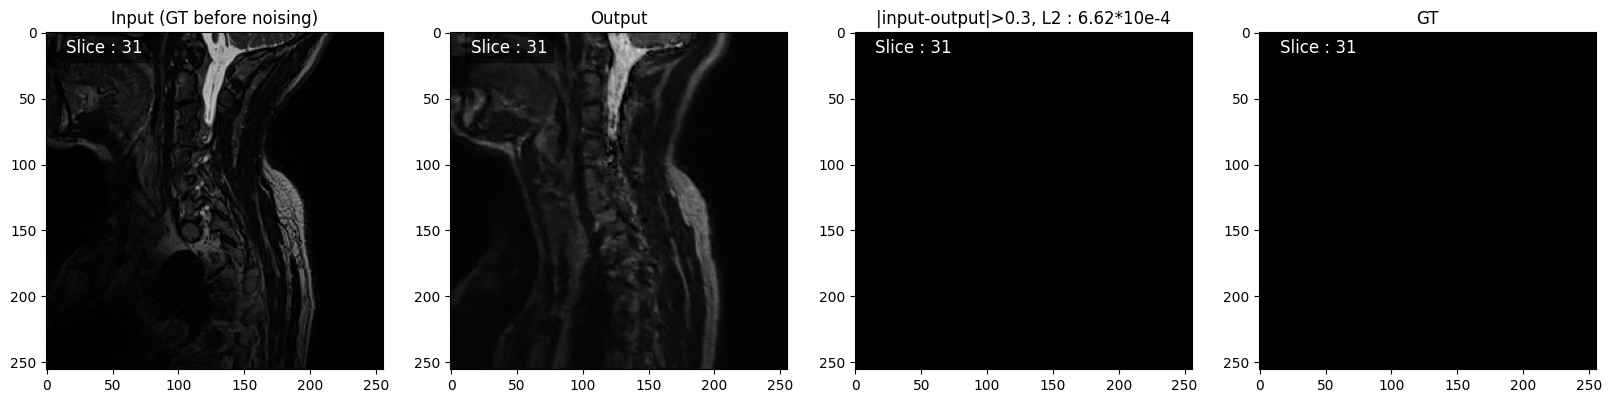

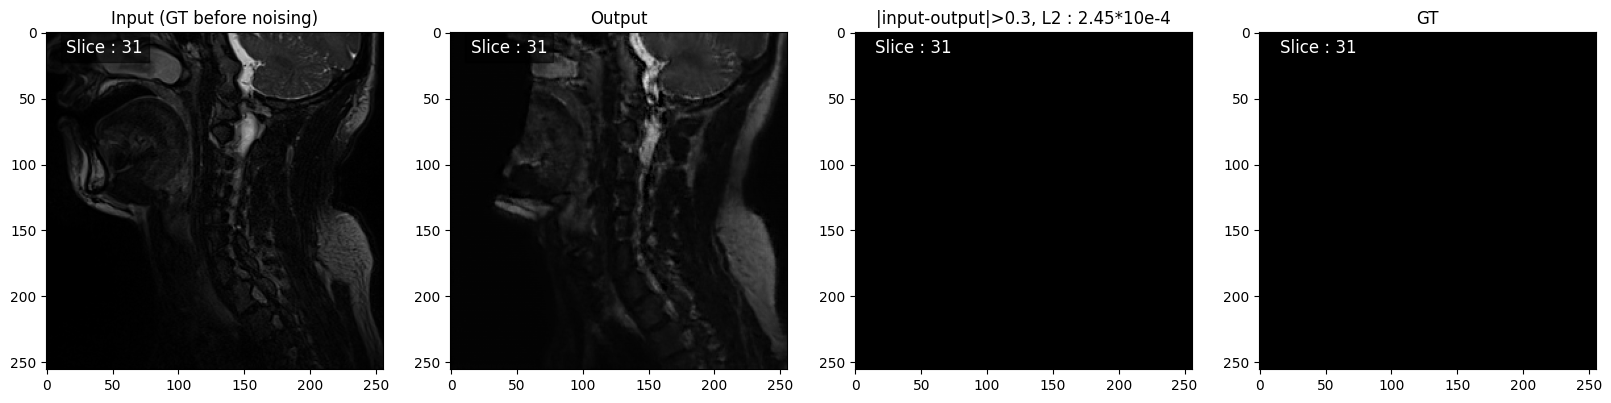

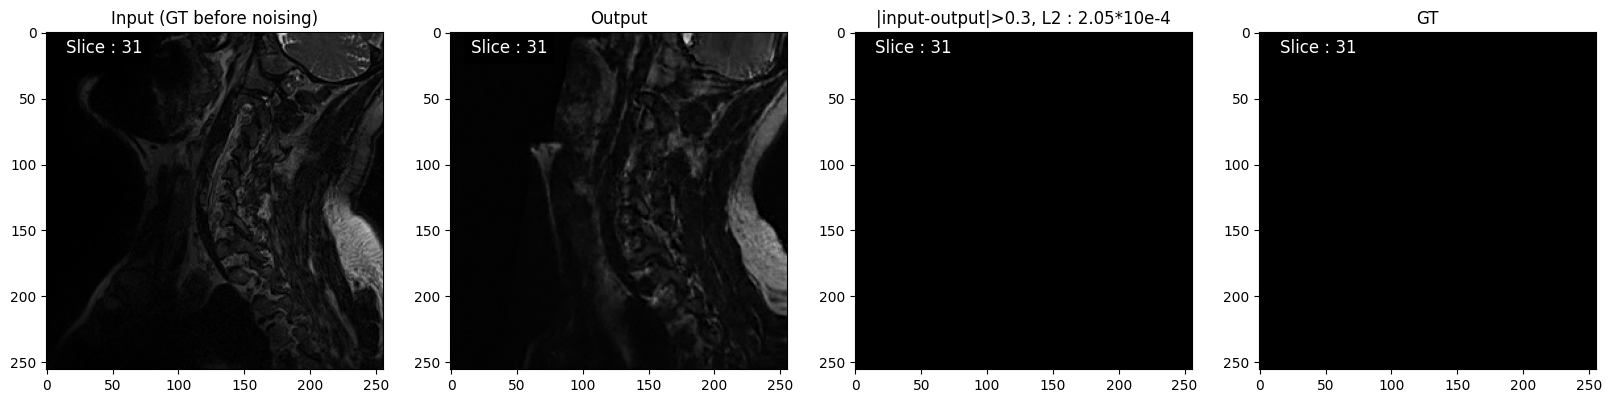

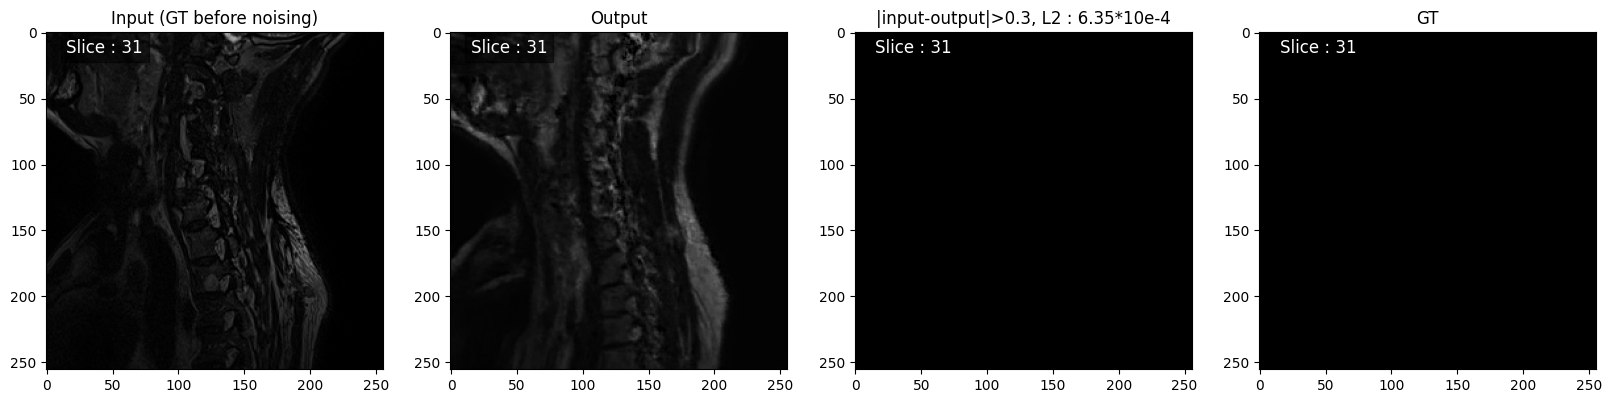

In [19]:
denosing = 0.25
segmentation = "seg-manual"
output_folder="/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/infered_figures"
lesion_segmentation_threshold = 0.30
mode = 'gif'
for sample_index in range(13):
    sample = train_dataset[sample_index]
    input_, noised_input, output, comparison = img2img(sample, denoising = denosing, comparison_mode = "Unsigned_difference", segmentation = segmentation)

    
    GT = normalize(sample["lesion-manual"], min_ =0)
    
    plot_img2img_segmentation(input_, output, comparison, GT, f"{output_folder}/lesion_segmentaiton_tr_{lesion_segmentation_threshold}_{mode}_sci_paris_{sample_index}_d={str(round(denosing,2))}_{segmentation}", denosing, mode = mode, lesion_segmentation_threshold = lesion_segmentation_threshold)

In [13]:
# use the function to get the input, noised input, output and comparison for a range of denoising values
sample_index = 8
denoising_values = np.arange(0.0, 1.0, 0.05)
sample = train_dataset[sample_index]
input_, noised_inputs, outputs, comparisons = img2img_denoising_range(sample, denoising_values, comparison_mode = "Unsigned_difference")

/tmp/ipykernel_735243/1739846049.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(sample['data'][None]).to(device)


0


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]


15


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   0%|          | 1/300 [00:00<01:43,  2.89it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   1%|          | 2/300 [00:00<01:47,  2.78it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   1%|          | 3/300 [00:01<01:48,  2.74it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   1%|▏         | 4/300 [00:01<01:48,  2.72it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   2%|▏         | 5/300 [00:01<01:48,  2.72it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   2%|▏         | 6/300 [00:02<01:48,  2.70it/s]

input temporal_attn :torch.Size([1, 1024, 16, 16, 16])
input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32,

sampling loop time step:   2%|▏         | 7/300 [00:02<01:48,  2.70it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   3%|▎         | 8/300 [00:02<01:48,  2.70it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   3%|▎         | 9/300 [00:03<01:47,  2.70it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   3%|▎         | 10/300 [00:03<01:47,  2.69it/s]

input temporal_attn :torch.Size([1, 1024, 16, 16, 16])
input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32,

sampling loop time step:   4%|▎         | 11/300 [00:04<01:47,  2.69it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   4%|▍         | 12/300 [00:04<01:46,  2.69it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   4%|▍         | 13/300 [00:04<01:46,  2.69it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   5%|▍         | 14/300 [00:05<01:46,  2.69it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   5%|▌         | 15/300 [00:05<01:45,  2.70it/s]


30


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   0%|          | 1/300 [00:00<01:44,  2.87it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   1%|          | 2/300 [00:00<01:47,  2.76it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   1%|          | 3/300 [00:01<01:49,  2.72it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   1%|▏         | 4/300 [00:01<01:49,  2.70it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   2%|▏         | 5/300 [00:01<01:49,  2.71it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   2%|▏         | 6/300 [00:02<01:48,  2.70it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   2%|▏         | 7/300 [00:02<01:48,  2.69it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   3%|▎         | 8/300 [00:02<01:48,  2.69it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   3%|▎         | 9/300 [00:03<01:48,  2.69it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   3%|▎         | 10/300 [00:03<01:47,  2.69it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   4%|▎         | 11/300 [00:04<01:47,  2.70it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   4%|▍         | 12/300 [00:04<01:46,  2.70it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   4%|▍         | 13/300 [00:04<01:46,  2.70it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   5%|▍         | 14/300 [00:05<01:45,  2.70it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   5%|▌         | 15/300 [00:05<01:45,  2.70it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   5%|▌         | 16/300 [00:05<01:44,  2.71it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   6%|▌         | 17/300 [00:06<01:44,  2.70it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   6%|▌         | 18/300 [00:06<01:44,  2.70it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   6%|▋         | 19/300 [00:07<01:43,  2.71it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   7%|▋         | 20/300 [00:07<01:43,  2.70it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   7%|▋         | 21/300 [00:07<01:43,  2.71it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   7%|▋         | 22/300 [00:08<01:42,  2.71it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32]

sampling loop time step:   8%|▊         | 23/300 [00:08<01:42,  2.71it/s]

el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])
input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
inpu

sampling loop time step:   8%|▊         | 24/300 [00:08<01:42,  2.70it/s]

input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([1, 1024, 16, 16, 16])
el famoso len slef.downs
4
input block1 :torch.Size([1, 128, 16, 128, 128])
input block2 :torch.Size([1, 128, 16, 128, 128])
input spatial_attn :torch.Size([1, 128, 16, 128, 128])
input temporal_attn :torch.Size([1, 128, 16, 128, 128])


sampling loop time step:   8%|▊         | 24/300 [00:09<01:45,  2.62it/s]

input downsample :torch.Size([1, 128, 16, 128, 128])
output downsample :torch.Size([1, 128, 16, 64, 64])
input block1 :torch.Size([1, 128, 16, 64, 64])
input block2 :torch.Size([1, 256, 16, 64, 64])
input spatial_attn :torch.Size([1, 256, 16, 64, 64])
input temporal_attn :torch.Size([1, 256, 16, 64, 64])
input downsample :torch.Size([1, 256, 16, 64, 64])
output downsample :torch.Size([1, 256, 16, 32, 32])
input block1 :torch.Size([1, 256, 16, 32, 32])
input block2 :torch.Size([1, 512, 16, 32, 32])
input spatial_attn :torch.Size([1, 512, 16, 32, 32])
input temporal_attn :torch.Size([1, 512, 16, 32, 32])
input downsample :torch.Size([1, 512, 16, 32, 32])
output downsample :torch.Size([1, 512, 16, 16, 16])
input block1 :torch.Size([1, 512, 16, 16, 16])
input block2 :torch.Size([1, 1024, 16, 16, 16])
input spatial_attn :torch.Size([1, 1024, 16, 16, 16])
input temporal_attn :torch.Size([1, 1024, 16, 16, 16])
input downsample :torch.Size([1, 1024, 16, 16, 16])
output downsample :torch.Size([

KeyboardInterrupt: 

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailab

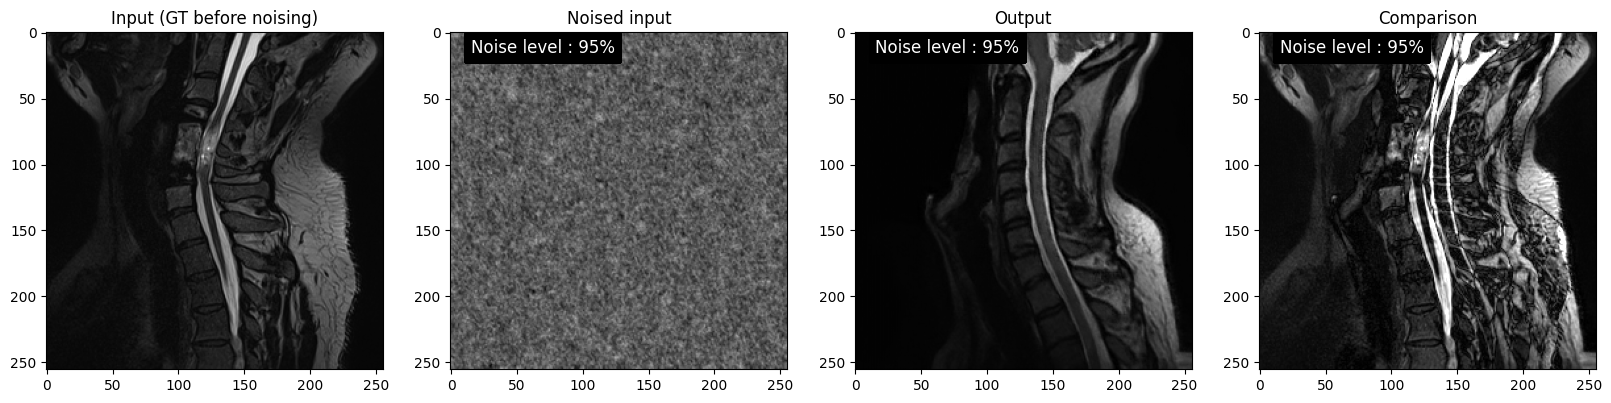

In [ ]:
output_folder="/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/infered_figures"
#plot the gif of the diffusion for a range of denoising values
plot_img2img_denoising_range(input_, noised_inputs, outputs, comparisons, denoising_values, f"{output_folder}/gif_canproco_{sample_index}_d_range", index = 16)